### Note: This is a kaggle notebook so the model was trained on a P100 GPU.

In [1]:
from duckduckgo_search import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [5]:
urls = search_images('healthy wheat leaf', max_images=1)
urls[0]

'https://yaraurl.com/fug6'

c:\Users\Shiven\anaconda3\envs\mpsem3\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


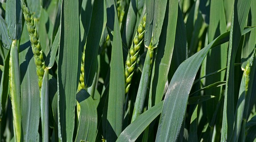

In [6]:
from fastdownload import download_url
dest = 'healthy_leaf.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

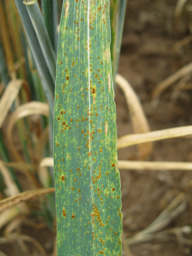

In [7]:
download_url(search_images('wheat leaf rust symptoms', max_images=1)[0], 'rust_disease.jpg', show_progress=False)
Image.open('rust_disease.jpg').to_thumb(256,256)

In [ ]:
searches = 'healthy wheat leaf', 'wheat leaf rust symptoms', 'wheat stem rust disease', 'wheat powdery mildew', 'Septoria Blotch Disease Wheat'
path = Path('Wheat')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

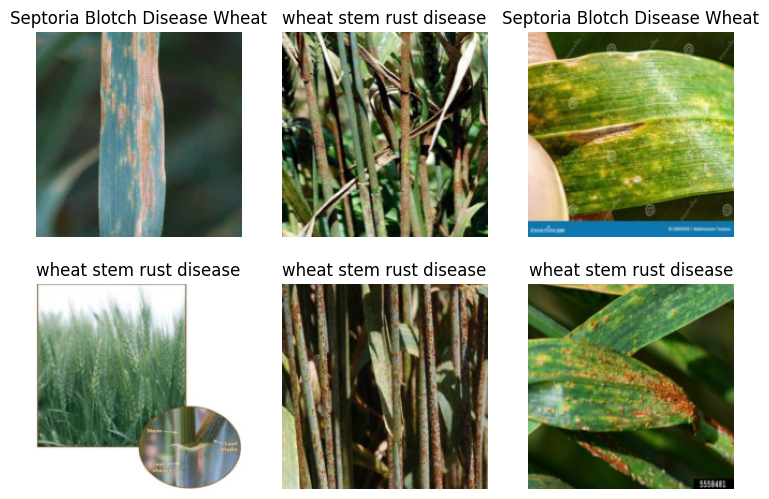

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.669709,1.677008,0.609929,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.642270,1.643855,0.553191,00:02
1,1.314448,1.800684,0.531915,00:02
2,1.017108,1.991080,0.574468,00:02
3,0.782508,2.036489,0.560284,00:02
4,0.640799,2.003489,0.546099,00:02


In [14]:
dest = 'powdery.jpg'
download_url('https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.queenslandcountrylife.com.au%2Fimages%2Ftransform%2Fv1%2Fcrop%2Ffrm%2Fya3tPqPRXYVuem2wchintR%2F01dd55da-af78-44e1-84ba-3dab6151b6d6.jpg%2Fr0_0_3120_1752_w1200_h678_fmax.jpg&f=1&nofb=1&ipt=24f7fb3dc747805cae11e1158a3ba11e3079e85fd743303a2c811f209bf8bd89&ipo=images', dest, show_progress=True)

Path('powdery.jpg')

In [15]:
is_healthy,_,probs = learn.predict(PILImage.create('powdery.jpg'))
print(f"Prediction: {is_healthy}, Confidence: {max(probs):.4f}")

Prediction: wheat powdery mildew, Confidence: 0.9669


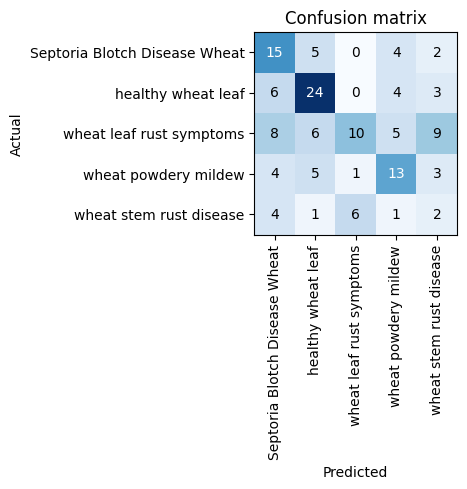

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [17]:
learn.export('wheat.pkl')